# Terminal state identification

Compares model performance based on terminal state identification.

## Library imports

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns
from matplotlib import rcParams

import cellrank as cr
import scanpy as sc
import scvelo as scv
import scvi

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.benchmarking import plot_TSI, TSI_score
from rgv_tools.core import METHOD_PALETTE_TSI
from rgv_tools.plotting._significance import add_significance, get_significance

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda

## General setting

In [2]:
scvi.settings.seed = 0

[rank: 0] Seed set to 0


In [3]:
plt.rcParams["svg.fonttype"] = "none"
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

## Constants

In [4]:
DATASET = "zebrafish"

SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

FIGURE_FORMATE = "svg"

In [5]:
VELOCITY_METHODS = ["regvelo", "scvelo", "velovi"]

In [6]:
TERMINAL_STATES = [
    "mNC_head_mesenchymal",
    "mNC_arch2",
    "mNC_hox34",
    "Pigment",
]

## Data loading

In [7]:
ks = {}

for method in VELOCITY_METHODS:
    adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / f"adata_run_{method}.h5ad")
    ## construct graph
    vk = cr.kernels.VelocityKernel(adata).compute_transition_matrix()
    ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
    ks[method] = 0.8 * vk + 0.2 * ck

100%|██████████| 697/697 [00:00<00:00, 3655.55cell/s]


## Terminal state identification

In [8]:
# define threshold from 0.1 to 1
thresholds = np.linspace(0.1, 1, 21)[:20]

In [9]:
estimators = {}
tsi = {}

In [10]:
for method in VELOCITY_METHODS:
    estimators[method] = cr.estimators.GPCCA(ks[method])
    tsi[method] = TSI_score(adata, thresholds, "cell_type", TERMINAL_STATES, estimators[method])

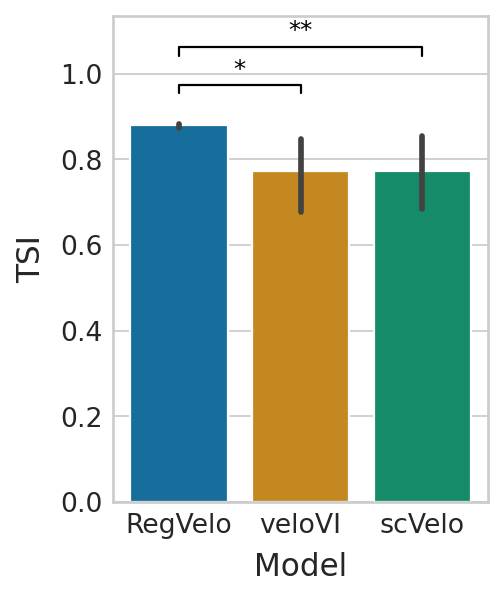

In [11]:
df = pd.DataFrame(
    {
        "TSI": tsi["regvelo"] + tsi["velovi"] + tsi["scvelo"],
        "Model": ["RegVelo"] * 20 + ["veloVI"] * 20 + ["scVelo"] * 20,
    }
)

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 4))

    sns.barplot(data=df, x="Model", y="TSI", palette="colorblind", ax=ax)

    ttest_res = ttest_ind(tsi["regvelo"], tsi["velovi"], alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax,
        left=0,
        right=1,
        significance=significance,
        lw=1,
        bracket_level=1.05,
        c="k",
        level=0,
    )

    ttest_res = ttest_ind(tsi["regvelo"], tsi["scvelo"], alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(ax=ax, left=0, right=2, significance=significance, lw=1, c="k", level=2, bracket_level=0.9)

    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max + 0.02])

    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / DATASET / "tsi_benchmark.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show()

## Visualize terminal states

In [12]:
tsi_rgv_curve = plot_TSI(adata, estimators["regvelo"], 0.8, TERMINAL_STATES, "cell_type")
tsi_scv_curve = plot_TSI(adata, estimators["scvelo"], 0.8, TERMINAL_STATES, "cell_type")
tsi_vi_curve = plot_TSI(adata, estimators["velovi"], 0.8, TERMINAL_STATES, "cell_type")

## Plotting

In [13]:
df = pd.DataFrame(
    {
        "number_macrostate": range(0, 12),
        "RegVelo": [0] + tsi_rgv_curve,
        "veloVI": [0] + tsi_vi_curve,
        "scVelo": [0] + tsi_scv_curve,
    }
)

In [14]:
df = pd.melt(df, ["number_macrostate"])

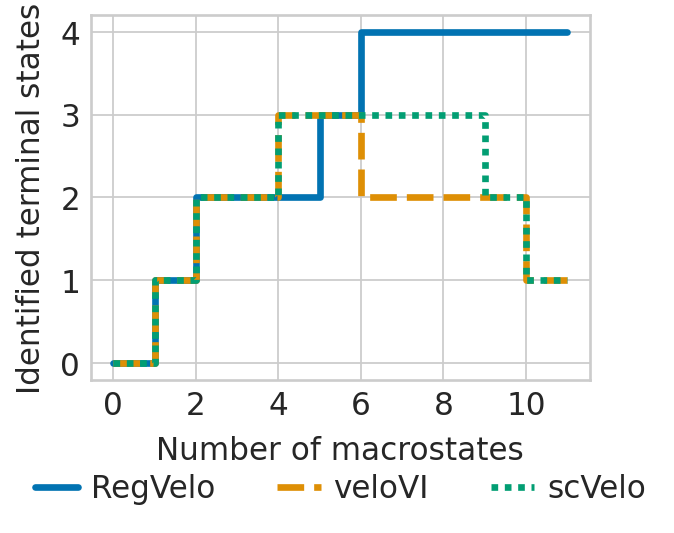

In [15]:
# Set figure size
with mplscience.style_context():
    sns.set_style(style="whitegrid")

    rcParams["figure.figsize"] = 4, 3

    # Plot the grid plot
    ax = sns.lineplot(
        x="number_macrostate",
        y="value",
        hue="variable",
        style="variable",
        palette=METHOD_PALETTE_TSI,
        drawstyle="steps-post",
        data=df,
        linewidth=3,
    )

    # Set labels and titles
    ax.set(ylabel="Number of correct predictions")
    plt.xlabel("Number of macrostates", fontsize=14)
    plt.ylabel("Identified terminal states", fontsize=14)

    # Customize tick parameters for better readability
    ax.set_xticks([0, 2, 4, 6, 8, 10])
    ax.set_xticklabels([0, 2, 4, 6, 8, 10])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18), shadow=True, ncol=4, fontsize=14)

    if SAVE_FIGURES:
        plt.savefig(
            FIG_DIR / DATASET / "state_identification_update.svg", format="svg", transparent=True, bbox_inches="tight"
        )
    plt.show()